# Read a Graph

### Data is the currency of science, but it is packaged in figures

Can we unpackage data and re-use it?

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import scipy.ndimage as ndimage
# try:
#     import Image
# except ImportError:
from PIL import Image
import pytesseract as tes

import sys
sys.path.insert(0, './functions')
import ocr_tools
import find_axes
from thresholding import adaptive_thresh

print('All packages loaded')

All packages loaded


<IPython.core.display.Javascript object>


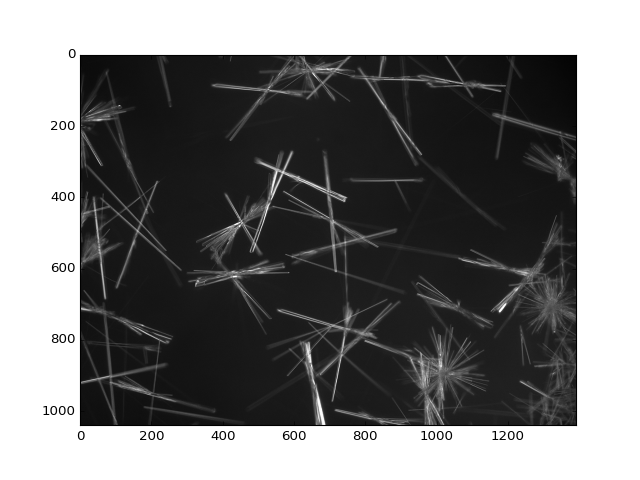

In [2]:
example = 'Matt30.tif'
img = cv2.imread(example)
m,n,p=img.shape

%matplotlib notebook
implot = plt.imshow(img)

## This is our starting point

We would like to find the axes, calibrate them from pixel to data space, find the data and extract it.

<IPython.core.display.Javascript object>


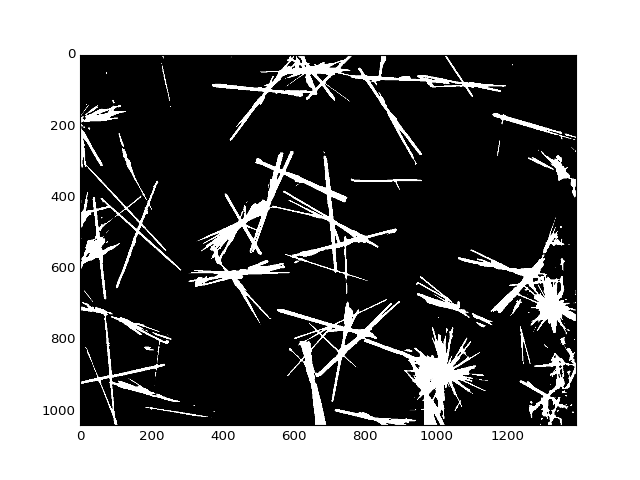

In [20]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edge = cv2.Canny(gray, 30, 100)
# bw4 = adaptive_thresh(gray)
# nbw = (255-bw4)

%matplotlib notebook
implot = plt.imshow(th3, cmap='gray')

### Every image processing workflow starts with a threshold

Many features are available from the black and white image. We will start with a simple one: lines. These are extracted through a Hough Transform

In [60]:
linesP = cv2.HoughLinesP(th3,0.01,np.pi/1000,1, minLineLength = 100, maxLineGap = 10)[0]
print('Hough Transform complete')
linesP.shape

Hough Transform complete


(323, 4)

In [61]:
lineList = linesP.tolist()
lineX = [[x1,x2] for x1,y1,x2,y2 in lineList]
lineY = [[y1,y2] for x1,y1,x2,y2 in lineList]
len(lineX)

323

In [62]:
imsize=gray.shape
imsize[0]

1040

In [63]:
from bokeh.plotting import figure, output_notebook, show

output_notebook()

scale=1.5

p = figure(plot_width=int(round(imsize[1]/scale)),
           plot_height=int(round(imsize[0]/scale)))
p.image([th3],0,0,imsize[1],imsize[0])
p.multi_line(lineX, lineY,
             line_width=3)

show(p)

Loading BokehJS ...

## So we've got some line segments.

Now we are going to engineer an axis feature score, for example, the x-axis:

[cos^2, fractional length, fractional y-coord (or x coord for y axis)]

"How horizontal is this line segment?"
"How long is it relative to the image size?"
"Where is it in the image?"

In [85]:
import find_axes
# print(linesP)
xax = find_axes.get_xaxis(linesP,nbw)
print('x axis')
print(xax)
yax = find_axes.get_yaxis(linesP,nbw)
print('y axis')
print(yax)

x axis
[ 96 339 457 339]
y axis
[ 94 339  94  15]


## Let's draw the results

<IPython.core.display.Javascript object>


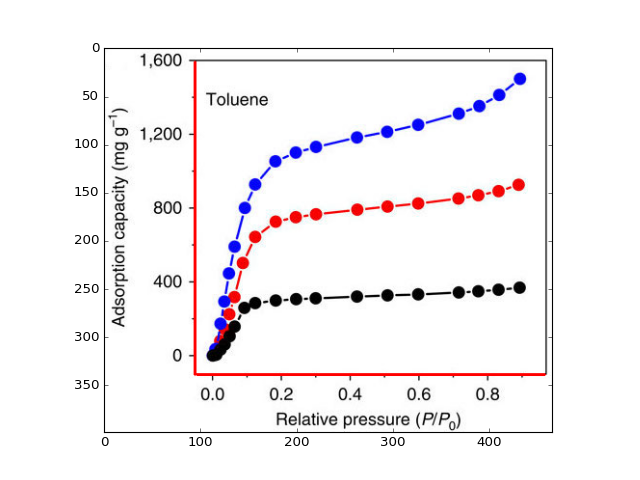

In [86]:
imlabel = img.copy();
cv2.line(imlabel,(xax[0],xax[1]),(xax[2],xax[3]),(255,0,0),2)
cv2.line(imlabel,(yax[0],yax[1]),(yax[2],yax[3]),(255,0,0),2)

%matplotlib notebook
implot = plt.imshow(imlabel)
implot.set_cmap('gray')

## Now let's find ticks and tick labels

It's actually easier to start by finding the labels - in fact, in many cases it's not necessary to even find the ticks at all.

OCR is difficult. Pytesseract is the best open source library for it, but it's not a panacea. We can help it by first isolating the region from which we'd like to extract text.

<IPython.core.display.Javascript object>


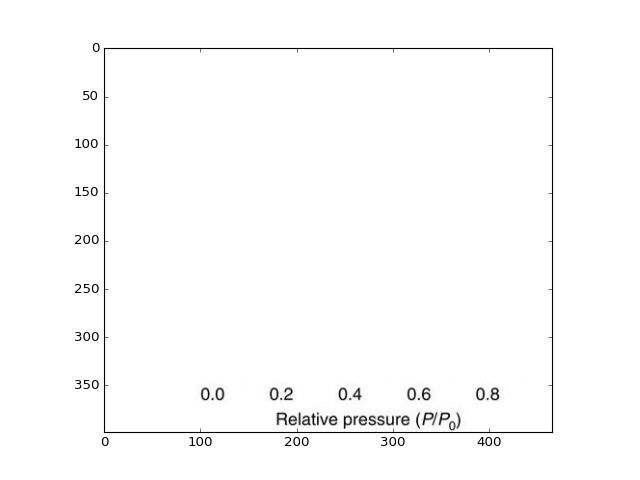

In [87]:
%matplotlib notebook

# Find where the x-ticks stop and crop the text image to be below that
below_xax_bw = np.zeros([m,n]).astype('uint8')
below_xax_bw[xax[1]:,:]=nbw[xax[1]:,:]
row_sums = below_xax_bw.sum(axis=1)
row_sums[0:xax[1]] = 1000
row_sums_list = row_sums.tolist()
text_crop_ind = row_sums_list.index(0)
text_crop_ind

xTextImg = np.ones([m,n,p]).astype('uint8')*255
xTextImg[text_crop_ind+1:,:,:]=img[text_crop_ind+1:,:,:]

cv2.imwrite('temp/xtext.png',xTextImg)
implot = plt.imshow(xTextImg)


In [88]:
xocr = tes.image_to_string(Image.open('temp/xtext.png'),boxes=True)
print('OCR complete')

OCR complete


In [89]:
import ocr_tools

words = ocr_tools.clean_ocr_results(xocr)
words

[['0.0', 101, 33, 125, 46],
 ['0.2', 172, 33, 196, 46],
 ['0.4', 244, 33, 267, 46],
 ['0.6', 315, 33, 339, 46],
 ['0.8', 386, 33, 410, 46],
 ['Relative', 179, 7, 242, 20],
 ['pressure', 249, 3, 317, 17],
 ['(P/PD)', 324, 2, 370, 20]]

### We're looking for numbers

Let's pick those out.

In [90]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

numbers = [w for w in words if is_number(w[0])]
for w in numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
xt_labels = np.array(numbers)

<IPython.core.display.Javascript object>


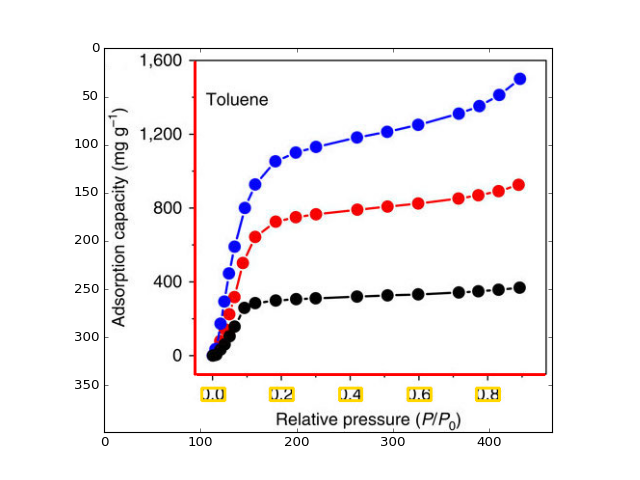

In [91]:
%matplotlib notebook

for w in numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

# Find X Ticks


### This is going to match tick labels with their nearest vertical line segment on the x-axis.

In [92]:
xt_dirty = find_axes.get_xticks(nbw,xax,tickMargin=11,minTickLen=0,maxGap=0)
xt_list=xt_dirty.tolist()

In [93]:
xt_match = find_axes.match_xticks(numbers,xt_list)
xt_pts = [xt_list[i] for i in xt_match]
xt_pts

[[112, 345, 112, 338],
 [184, 345, 184, 338],
 [255, 345, 255, 338],
 [327, 345, 327, 338],
 [398, 345, 398, 338]]

<IPython.core.display.Javascript object>


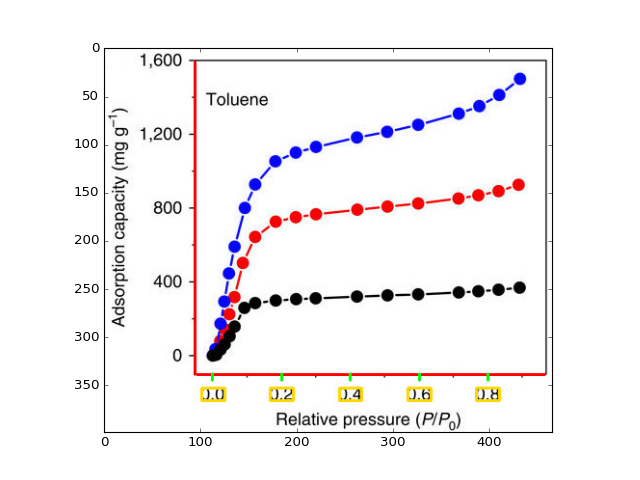

In [94]:
%matplotlib notebook
for x1,y1,x2,y2 in xt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [95]:
xt_pts_array = np.array(xt_pts)
xt_pts_array[:,0].reshape(-1,1)

print('X Axis in pixels')
print(xt_pts_array[:,0].reshape(-1,1))

X Axis in pixels
[[112]
 [184]
 [255]
 [327]
 [398]]


In [96]:
xt_labels[:,0].reshape(-1,1)
print('X Axis in Data')
print(xt_labels[:,0].reshape(-1,1))

X Axis in Data
[[ 0. ]
 [ 0.2]
 [ 0.4]
 [ 0.6]
 [ 0.8]]


## Convert x-axis from pixel space to data space with regression

We have a sort of calibration curve between pixel space and data space.

In [97]:
# %matplotlib notebook
# hcalib = plt.plot(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))
# plt.xlabel('pixels')
# plt.ylabel('x-axis data')

In [98]:
from sklearn import datasets, linear_model
regrx = linear_model.LinearRegression(fit_intercept=True)

regrx.fit(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regrx.coef_
print 'Intercept: \n', regrx.intercept_

Coefficients: 
[[ 0.00279719]]
Intercept: 
[-0.31384196]


## Now Get Y Ticks

In [99]:
# Find where the y-ticks stop and crop the text image to be left of that
left_yax_bw = np.zeros([m,n]).astype('uint8')
left_yax_bw[:yax[0],:]=nbw[:yax[0],:]
col_sums = left_yax_bw.sum(axis=0)
col_sums[yax[0]:] = 1000
col_zeros=np.where(col_sums==0)[0]
y_crop_ind=col_zeros[-1]
print('cropping y-axis region')

cropping y-axis region


<IPython.core.display.Javascript object>


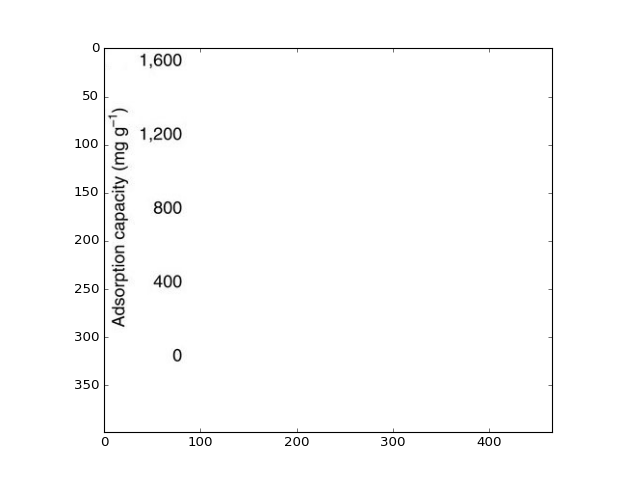

In [100]:
%matplotlib notebook
yTextImg = np.ones([m,n,p]).astype('uint8')*255
yTextImg[:,0:y_crop_ind-1,:]=img[:,0:y_crop_ind-1,:]

cv2.imwrite('temp/ytext.png',yTextImg)
implot = plt.imshow(yTextImg)

## Unfortunately

For OCR to work effectively on the y-axis, we must remove the rotated axis title completely. This is quite challenging.

<IPython.core.display.Javascript object>


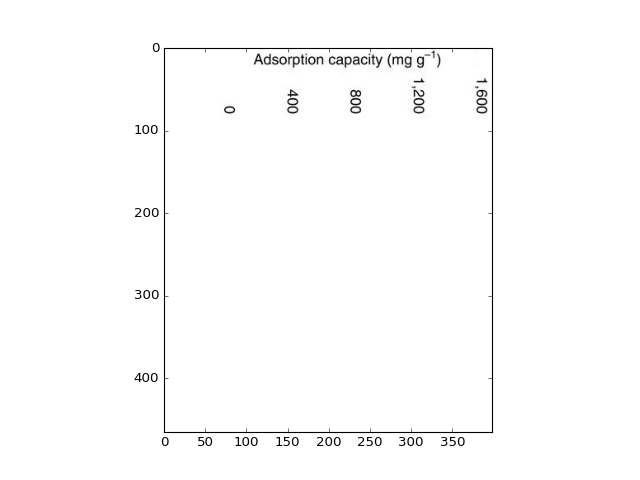

In [101]:
%matplotlib notebook

yTextRot = ndimage.interpolation.rotate(yTextImg, -90)
cv2.imwrite('temp/ytextrot.png',yTextRot)
implot = plt.imshow(yTextRot)
implot.set_cmap('gray')

In [102]:
yRotOcr = tes.image_to_string(Image.open('temp/ytextrot.png'),boxes=True)
print(yRotOcr)

A 109 445 120 458 0
d 121 445 130 458 0
s 131 445 139 455 0
o 140 445 149 455 0
v 151 445 155 455 0
p 156 441 165 455 0
l 166 445 170 457 0
x 172 445 173 454 0
o 175 444 184 455 0
n 185 445 193 455 0
c 200 445 208 455 0
a 209 445 218 455 0
p 219 441 228 455 0
a 229 445 238 455 0
c 239 445 247 455 0
i 248 445 250 458 0
t 251 445 256 457 0
y 257 441 265 454 0
( 271 441 275 458 0
m 277 445 290 455 0
g 292 441 300 455 0
g 307 441 315 455 0
" 316 452 328 462 0
) 331 441 335 458 0
g 150 405 163 414 0
m 226 405 239 414 0
h 300 406 316 418 0
o 150 395 163 404 0
o 226 395 239 404 0
O 303 395 316 404 0
o 150 385 163 394 0
o 226 385 239 394 0
o 303 385 316 394 0
O 379 385 392 394 0
O 379 395 392 404 0
S 379 405 392 414 0
' 377 416 381 418 0
l 379 423 392 428 0


### Find the longest "word" and clear its bounding box

In [103]:
yrot_words = ocr_tools.clean_ocr_results(yRotOcr,charspace=10)
word_length = [len(i[0]) for i in yrot_words]
longest_word = np.array(word_length).argmax()
lwbox = yrot_words[longest_word]
lwbox

['Adsovplxoncapacity(mgg")', 109, 441, 335, 462]

<IPython.core.display.Javascript object>


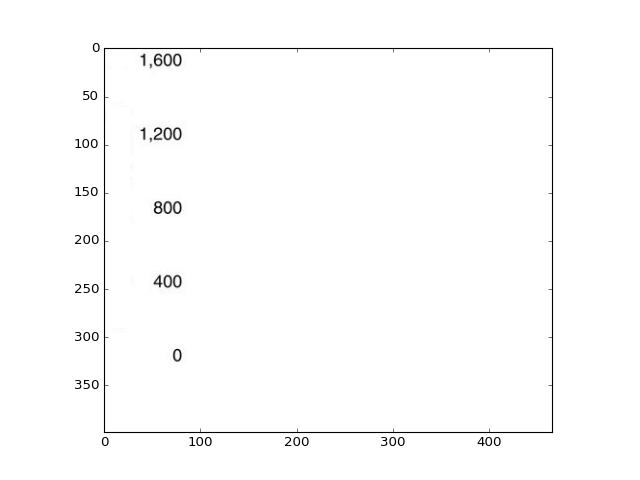

In [104]:
x1 = lwbox[1]-1
y1 = lwbox[2]-1
x2 = lwbox[3]+1
y2 = lwbox[4]+1
y1 = n-y1
y2 = n-y2
yTextRot[y2:y1+1,x1:x2+1,:] = np.ones([y1-y2+1,x2-x1+1,3]).astype('uint8')*255
yText_Clean = ndimage.interpolation.rotate(yTextRot, 90)

%matplotlib notebook
implot = plt.imshow(yText_Clean)

### Conventional OCR

In [105]:
cv2.imwrite('temp/ytextclean.png',yText_Clean)
yocr = tes.image_to_string(Image.open('temp/ytextclean.png'),boxes=True)
yl_ocr = ocr_tools.clean_ocr_results(yocr)
yl_ocr

[['1600', 38, 377, 81, 392],
 ['1200', 38, 300, 81, 316],
 ['800', 52, 226, 81, 239],
 ['400', 52, 150, 81, 163]]

In [106]:
yt_numbers = [w for w in yl_ocr if is_number(w[0])]
for w in yt_numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
yt_label_array = np.array(yt_numbers)

<IPython.core.display.Javascript object>


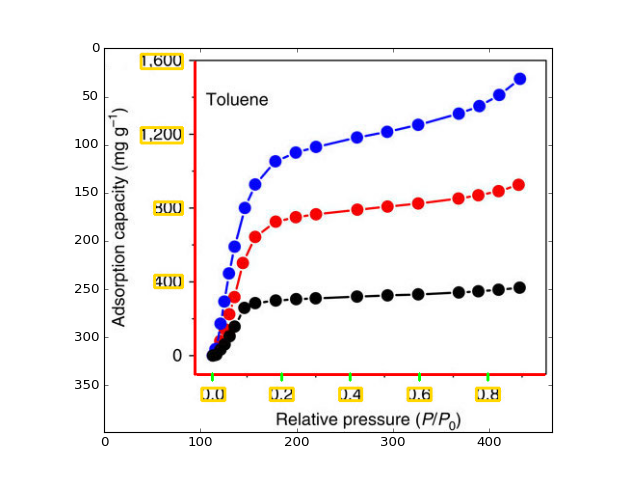

In [107]:
%matplotlib notebook

for w in yt_numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Now run the same label/tick matching algorithm for the y-axis

In [108]:
yt_dirty = find_axes.get_yticks(nbw,yax,tickMargin=11,minTickLen=0,maxGap=2)
yt_list=yt_dirty.tolist()
yt_match = find_axes.match_xticks(yt_numbers,yt_list)
yt_pts = [yt_list[i] for i in yt_match]
yt_pts

[[88, 15, 104, 15], [88, 91, 95, 91], [88, 167, 95, 167], [88, 244, 95, 244]]

<IPython.core.display.Javascript object>


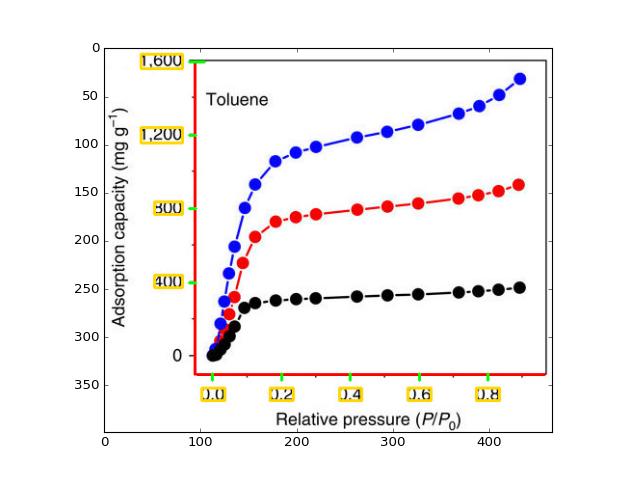

In [109]:
%matplotlib notebook
for x1,y1,x2,y2 in yt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [110]:
yt_pts_array = np.array(yt_pts)
print('y axis pixels')
print(yt_pts_array[:,1].reshape(-1,1))

y axis pixels
[[ 15]
 [ 91]
 [167]
 [244]]


In [111]:
print('y axis data')
print(yt_label_array[:,0].reshape(-1,1))

y axis data
[[ 1600.]
 [ 1200.]
 [  800.]
 [  400.]]


## Regress the y tick labels to the y ticks

In [112]:
from sklearn import datasets, linear_model
regry = linear_model.LinearRegression(fit_intercept=True)

regry.fit(yt_pts_array[:,1].reshape(-1,1), yt_label_array[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regry.coef_
print 'Intercept: \n', regry.intercept_

Coefficients: 
[[-5.24240993]]
Intercept: 
[ 1677.58148323]


## Finally, Extract the Data by Clustering

This is where the problem explodes. This is not a universal approach.

In [113]:
from color_series_scrape import color_series_scrape

pix_pts, ROI = color_series_scrape(example, [[xax[0],xax[2]]],[[yax[3],yax[1]]], n_colors=4)

print('Done clustering')

KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image
Done clustering


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


<IPython.core.display.Javascript object>


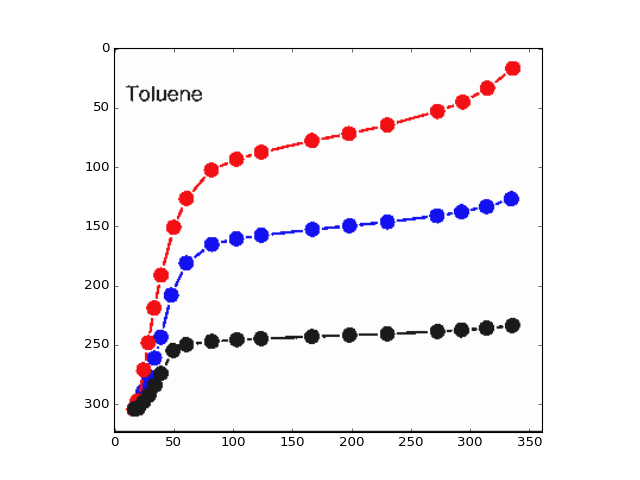

In [114]:
from cluster_data import cluster_colorspace_km, return_series

im_recon, im_label = cluster_colorspace_km(ROI[0], 4)
labels_as_ims = return_series(im_label)

%matplotlib notebook
plt.imshow(im_recon)

<IPython.core.display.Javascript object>


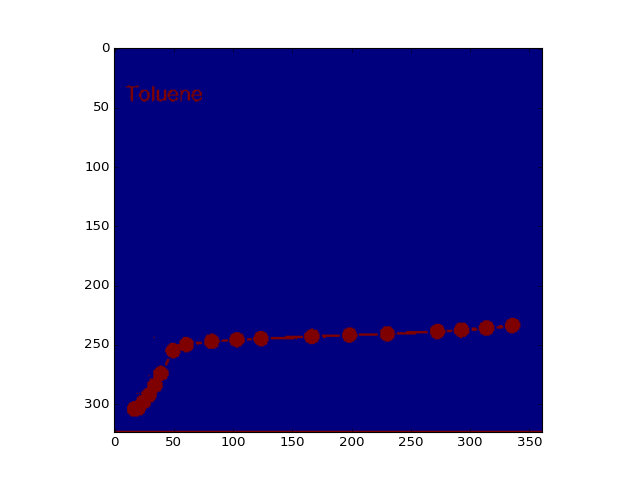

In [115]:
%matplotlib notebook

plt.imshow(labels_as_ims[0])

<IPython.core.display.Javascript object>


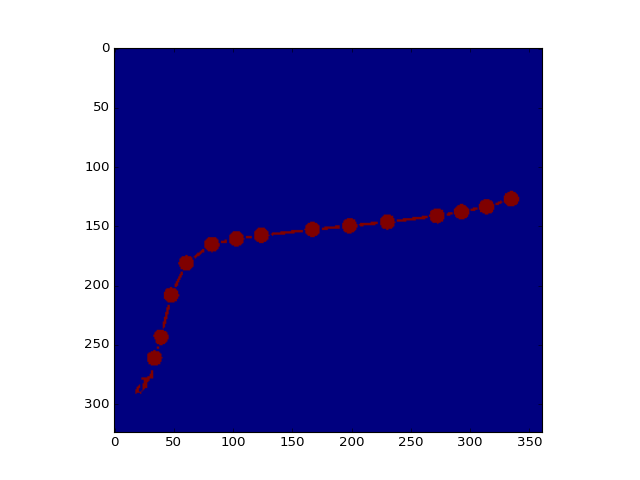

In [116]:
%matplotlib notebook

plt.imshow(labels_as_ims[1])

<IPython.core.display.Javascript object>


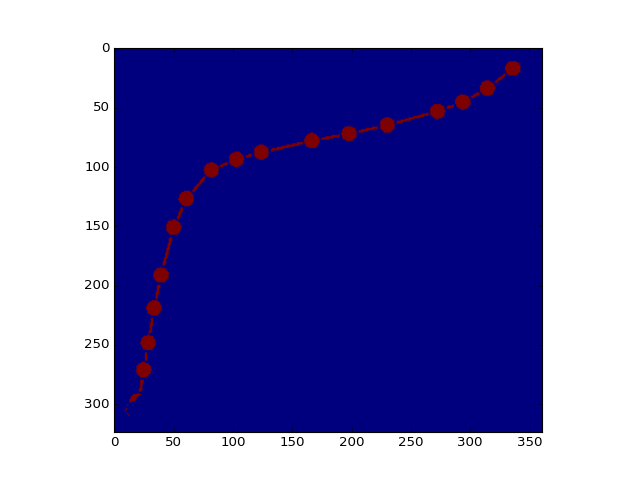

In [117]:
%matplotlib notebook

plt.imshow(labels_as_ims[2])

<IPython.core.display.Javascript object>


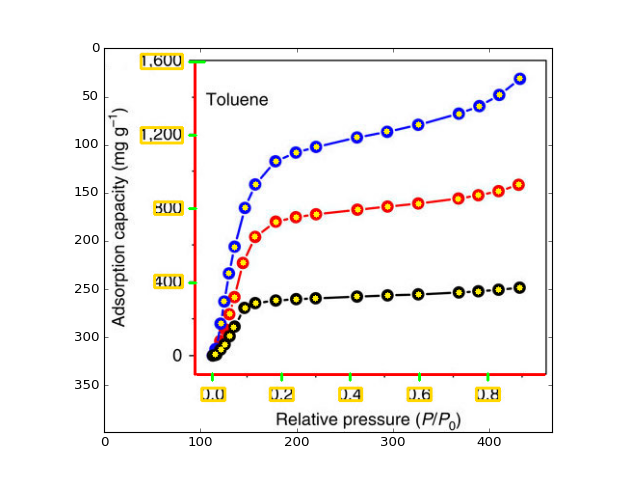

In [118]:
%matplotlib notebook
imlabel4 = imlabel.copy()
pp_list = []
for series in pix_pts[0]:
    s_list = []
    for tup in series:
        x = int(round(tup[1]))+xax[0]
        y = int(round(tup[0]))+yax[3]
        s_list.append([x,y])
    pp_list.append(s_list)

pp_list

for series in pp_list:
    for pt in series:
        cv2.circle(imlabel4,(pt[0],pt[1]), 3, (255,240,10), -1)


lastplot = plt.imshow(imlabel4)

## ... and convert the pixel values to the units of the axes

In [119]:
data_list = []
for series in pp_list:
    ser_list = []
    for pt in series:
        xdata = pt[0]*regrx.coef_+regrx.intercept_
        ydata = pt[1]*regry.coef_+regry.intercept_
        ser_list.append([xdata[0,0],ydata[0,0]])
    data_list.append(ser_list[::-1])

data_list

[[[0.007834469160531099, 10.495126035985777],
  [0.02461758745608611, 36.707175677416444],
  [0.035806332986456135, 62.919225318847339],
  [0.049792264899418626, 110.10091467342295],
  [0.060981010429788651, 157.28260402799833],
  [0.094547247020898673, 262.13080259372191],
  [0.12531629722941623, 288.34285223515258],
  [0.18405721126385877, 304.07008202001111],
  [0.24279812529830136, 309.31249194829729],
  [0.29874185295015143, 314.55490187658347],
  [0.41902086740162903, 325.03972173315583],
  [0.59804079588754921, 335.52454158972819],
  [0.50853083164458912, 330.28213166144201],
  [0.71552262395643429, 346.00936144630055],
  [0.77146635160828447, 351.25177137458672],
  [0.83020726564272707, 361.73659123115908],
  [0.89174536605976207, 372.22141108773144]],
 [[0.049792264899418626, 230.67634302400484],
  [0.063778196812381172, 319.79731180486965],
  [0.088952874255713688, 508.52406922317186],
  [0.12251911084682371, 650.06913728689824],
  [0.18405721126385877, 728.70528621119092],
 

## Broader Problem: How to identify Graphs?

In [120]:
spat_stats_path = '/Users/Imperssonator/CC/MIC-Pres/SS PCA presentation/Slide1.tiff'
ss_img = cv2.imread(spat_stats_path)

<IPython.core.display.Javascript object>


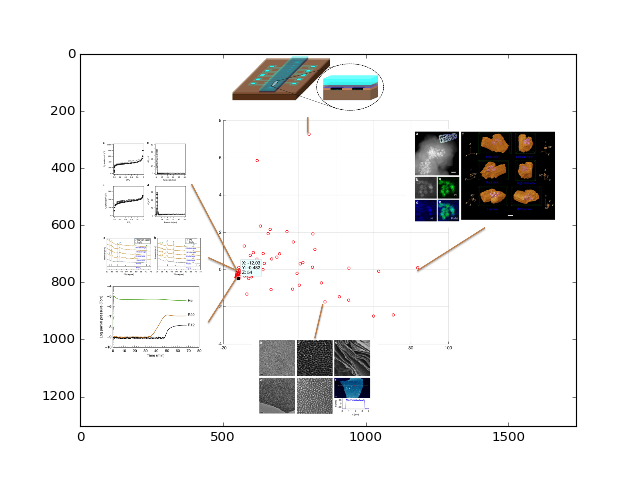

In [121]:
%matplotlib notebook
plt.imshow(ss_img)